# Visualisations - Analyse des Alertes ANSSI & Enrichissement CVE

## Imports et nettoyage

### Imports et chemins

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
import sys, csv, json

# Racine = dossier parent de notebooks/
PROJECT_ROOT = Path.cwd().resolve().parent
print("📁 Racine projet :", PROJECT_ROOT)

# modules internes
sys.path.insert(0, str(PROJECT_ROOT))

# Fichiers
DATA_CSV   = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR = PROJECT_ROOT / "outputs";  OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

📁 Racine projet : /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ
CSV présent : True - /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/data/processed/final_dataset.csv


### Lecture et nettoyage du jeu de données

In [2]:
df = pd.read_csv(
    DATA_CSV,
    parse_dates=["date", "closed_at", "cve_pub"],
    keep_default_na=False
).replace({"n/a": np.nan, "": np.nan})

# Types numériques explicites
num_cols = ["cvss_score", "epss_score", "epss_percentile", "lag_anssi_days"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Explosion des versions (facultatif mais utile)
df = df.explode("versions")

# Dédoublonnage
df = df.drop_duplicates(subset=["cve", "vendor_std", "produit", "versions"])

# Sous-ensemble sûr pour graphiques existants
df_visu = (df.dropna(subset=["cvss_score", "epss_score"]).copy())
df_unique = df.drop_duplicates(subset=["cve"]).copy()

print("✅ Dataset nettoyé :", df_visu.shape)

✅ Dataset nettoyé : (5726, 22)


## Analyse des vulnérabilités globales

### Scatter « CVSS × EPSS »

Nous cherchons à identifier des vulnérabilités à la fois graves ET probables, soit celles situées dans le quart supérieur droit du graphique.

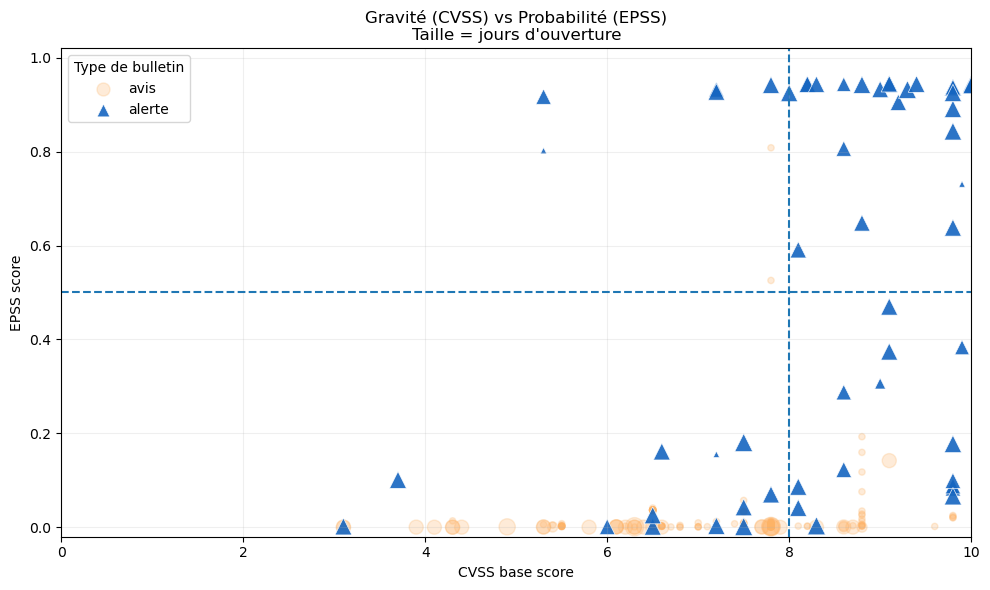

35 urgences enregistrées → /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/outputs/urgences_cve.csv


In [3]:
# 1. Filtrage des scores valides uniquement (sans redédupliquer)
df_visu_unique = df_unique.dropna(subset=["cvss_score", "epss_score"]).copy()

# 2. Calcul de la taille des points (logarithme des jours d'ouverture)
df_visu_unique["size_pt"] = np.log1p(df_visu_unique["days_open"]).fillna(0) * 30

# 3. Création du nuage de points
plt.figure(figsize=(10, 6))

# Avis
sub_avis = df_visu_unique[df_visu_unique["type"] == "avis"]
plt.scatter(sub_avis["cvss_score"], sub_avis["epss_score"],
            s=sub_avis["size_pt"], c="#FDB366", alpha=0.25,
            label="avis", marker="o")

# Alertes
sub_ale = df_visu_unique[df_visu_unique["type"] == "alerte"]
plt.scatter(sub_ale["cvss_score"], sub_ale["epss_score"],
            s=sub_ale["size_pt"], c="#1565C0", alpha=0.9,
            label="alerte", marker="^", edgecolors="white", linewidths=0.5)

plt.axvline(8, linestyle="--")
plt.axhline(0.5, linestyle="--")
plt.xlabel("CVSS base score")
plt.ylabel("EPSS score")
plt.title("Gravité (CVSS) vs Probabilité (EPSS)\nTaille = jours d'ouverture")
plt.xlim(0, 10)
plt.ylim(-0.02, 1.02)
plt.legend(title="Type de bulletin")
plt.grid(alpha=.2)
plt.tight_layout()
plt.show()

# 4. Export des CVE urgentes (quart supérieur droit)
urg = df_visu_unique[(df_visu_unique["cvss_score"] >= 8) & (df_visu_unique["epss_score"] >= 0.5)]
urg.to_csv(OUTPUT_DIR / "urgences_cve.csv", index=False, encoding="utf-8")
print(f"{len(urg)} urgences enregistrées → {OUTPUT_DIR/'urgences_cve.csv'}")


Parmi les points situés dans la zone critique, nous observons plusieurs vulnérabilités qui cumulent :
* CVSS très élevé (souvent 9 à 10)
* EPSS proche de 1 : les failles sont hautement exploitables
* `days_open` très élevés pour certaines failles ce qui montre une exposition prolongée
* Des vulnérabilités publiées dans des produits critiques : Microsoft, Ivanti, GitLab, Cisco, SAP, Atlassian, etc.

Ces points sont donc nos urgences absolues : score technique élevé ET probabilité d’exploitation réelle. Cela permet également de montrer par exemple qu'une faille avec CVSS 10 mais EPSS 0.01 n’est pas forcément prioritaire (faible exploitation en pratique). Tandis qu'une faille à CVSS 7.5 mais EPSS 0.95 peut être plus risquée sur le terrain.

Le fait que Microsoft, Ivanti, Cisco, Atlassian ressortent régulièrement sont des indicateurs d'exposition. En effet, les produits concernés couvrent aussi bien OS, outils DevOps, sécurité, bases de données...

On peut ainsi distinguer le profil des alertes à envoyer en toutes circonstances si elles réunissent ces critères.

### Violin plot EPSS par quartile CVSS

On cherche ici à savoir si les vulnérabilités les plus graves (CVSS élevé) sont aussi les plus susceptibles d’être exploitées (EPSS élevé). Cette visualisation permet donc de voir la densité des valeurs EPSS dans chaque groupe CVSS (Q1 à Q4), et d’observer leur dispersion, asymétrie, et tendance centrale.

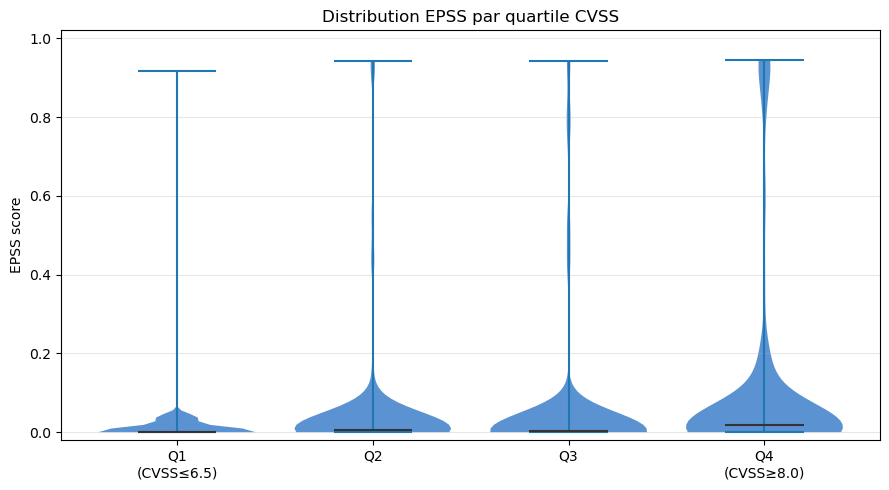

In [4]:
# 1. Conserver uniquement lignes scorées
d = df.dropna(subset=["cvss_score", "epss_score"]).copy()

# 2. Quartiles basés sur la distribution CVSS
d["cvss_quartile"] = pd.qcut(d["cvss_score"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

# 3. Préparer les données pour le violin plot
grouped_epss = [d[d["cvss_quartile"] == q]["epss_score"] for q in ["Q1", "Q2", "Q3", "Q4"]]

plt.figure(figsize=(9, 5))
parts = plt.violinplot(
    grouped_epss,
    showmeans=False,
    showmedians=True,
    widths=0.8
)

# 4. Esthétique basique
for pc in parts["bodies"]:
    pc.set_facecolor("#1565C0")
    pc.set_alpha(0.7)

median_color = "#333333"
parts["cmedians"].set_color(median_color)

quartile_labels = [
    f"Q1\n(CVSS≤{d['cvss_score'].quantile(0.25):.1f})",
    "Q2",
    "Q3",
    f"Q4\n(CVSS≥{d['cvss_score'].quantile(0.75):.1f})",
]

plt.xticks(
    ticks=[1, 2, 3, 4],
    labels=quartile_labels
)
plt.ylabel("EPSS score")
plt.title("Distribution EPSS par quartile CVSS")
plt.ylim(-0.02, 1.02)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### Histogramme empilé des scores CVSS

On cherche ici à analyser la distribution des niveaux de gravité CVSS (Common Vulnerability Scoring System) des vulnérabilités documentées dans les bulletins avis et alertes de l’ANSSI. On peut ainsi visualiser les plages de gravité les plus fréquentes et identifier les zones critiques (CVSS ≥ 7, 8 ou 9), souvent associées à des failles exploitables ou très graves.

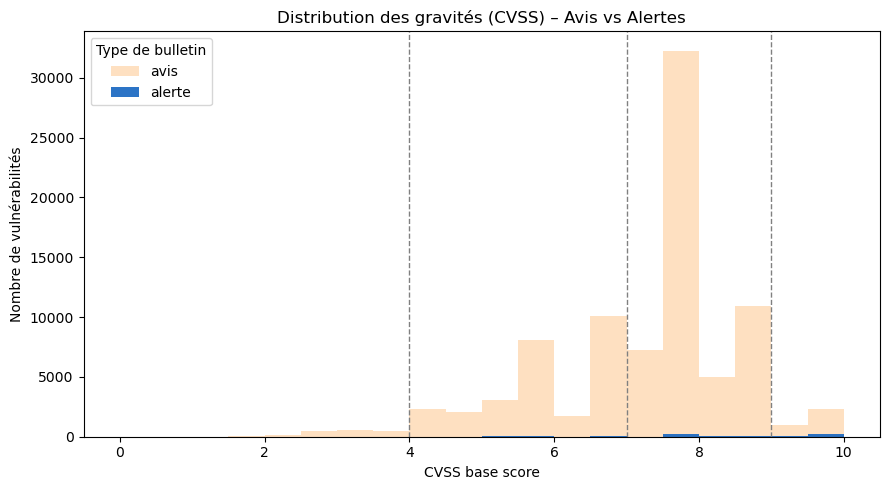

In [5]:
# 1. Sélection des scores valides
avis_cvss     = df[df["type"] == "avis"]["cvss_score"].dropna()
alertes_cvss  = df[df["type"] == "alerte"]["cvss_score"].dropna()

# 2. Bins 0 → 10 par pas de 0.5
bins = np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9, 5))

# 1. Avis en premier
plt.hist(
    avis_cvss,
    bins=bins,
    color="#FDB366",
    alpha=0.4,
    label="avis",
)

# 2. Alertes par-dessus
plt.hist(
    alertes_cvss,
    bins=bins,
    color="#1565C0",
    alpha=0.9,
    label="alerte",
    stacked=True  # pas indispensable ici, mais garde le même rendu
)

# seuils CVSS
for x in (4, 7, 9):
    plt.axvline(x, linestyle="--", color="grey", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("Nombre de vulnérabilités")
plt.title("Distribution des gravités (CVSS) – Avis vs Alertes")
plt.legend(title="Type de bulletin")
plt.tight_layout()
plt.show()

On remarque clairement que les bins de 5.0 à 7.0 regroupent une très grande proportion des vulnérabilités (plus de 11 000). Un pic net dans le bin [7.5–8.0[ avec 9780 vulnérabilités (dont 236 alertes).

Les avis représentent la majorité des enregistrements, ce qui reflète le rôle de l’ANSSI dans la veille large. Toutefois, les alertes, bien que minoritaires, apparaissent massivement dans les scores les plus élevés.

La zone critique (CVSS ≥ 9.0) contient un total de 1173 vulnérabilités, dont 260 alertes. Cela montre que plus de 22% des vulnérabilités très graves font l’objet d’alertes, bien plus que dans les autres bins.

Pour la suite de notre projet, cette visualiation montre que les bins supérieurs (≥ 8.0) doivent faire l’objet d’un suivi renforcé. Un focus sur les alertes dans cette plage permet de filtrer les CVE les plus urgentes. Aussi, le fait que les alertes soient concentrées dans les scores élevés confirme la stratégie de publication ciblée de l’agence.

On remarque que la majorité des vulnérabilités, quel que soit le quartile CVSS, ont un score EPSS très faible. Toutefois, on observe une augmentation progressive de la dispersion EPSS au fil des quartiles. Entre autres, le quartile Q4 (CVSS ≥ 8.0) montre une queue plus étendue vers les scores EPSS élevés, ce qui confirme visuellement que les vulnérabilités les plus graves sont aussi celles qui ont le plus de chances d’être exploitées, bien que cela reste marginal à l’échelle globale.

Cela confirme donc bien l’intérêt de croiser CVSS et EPSS car se baser uniquement sur la gravité (CVSS) néglige la faible exploitabilité de la majorité des vulnérabilités.

### Courbe cumulative des vulnérabilités en fonction du temps

On cherche à suivre l’évolution dans le temps du volume total de vulnérabilités recensées par l’ANSSI et comparer les dynamiques des deux types de bulletins (avis et alertes).

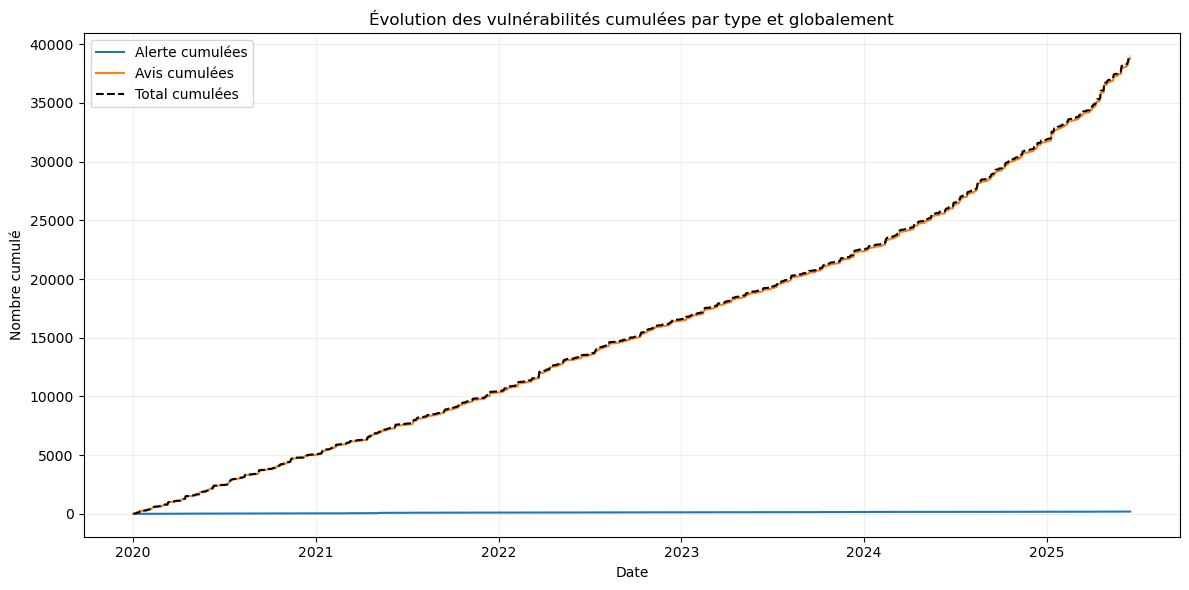

In [6]:
plt.figure(figsize=(12, 6))

# 1. Regrouper par date et type (df_unique contient déjà 1 ligne par CVE)
vuln_cum_par_type = (
    df_unique.groupby(["date", "type"])
             .size()
             .unstack(fill_value=0)
             .sort_index()
             .cumsum()
)

# 2. Tracer les courbes par type
for col in vuln_cum_par_type.columns:
    plt.plot(
        vuln_cum_par_type.index,
        vuln_cum_par_type[col],
        label=f"{col.capitalize()} cumulées"
    )

# 3. Courbe cumulée globale (total sans distinction de type)
vuln_cum_total = (
    df_unique.groupby("date")
             .size()
             .sort_index()
             .cumsum()
)

plt.plot(
    vuln_cum_total.index,
    vuln_cum_total.values,
    color="black",
    linestyle="--",
    label="Total cumulées"
)

plt.xlabel("Date")
plt.ylabel("Nombre cumulé")
plt.title("Évolution des vulnérabilités cumulées par type et globalement")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


On remarque qu'avant 2023, le nombre cumulé d’avis (et donc de CVE) reste faible et stable. Puis à partir de début 2023, on observe une forte accélération : la pente devient très raide, notamment en 2024.

Toutefois, on voit bien que la courbe des alertes est quasiment plate, ce qui signifie que très peu d’alertes ont été publiées.

### Stacked Area : Total des vulnérabilités vs subsets "CVSS >= 8 et EPSS >= 0.5"

Nous cherchons ici à suivre mensuellement l’évolution du volume de vulnérabilités, tout en mettant en évidence :
* Les vulnérabilités "dangereuses" (CVSS ≥ 8),
* Les vulnérabilités "urgentes" (EPSS ≥ 0.3),
* Et surtout les vulnérabilités "critiques", cumulant CVSS ≥ 8 et EPSS ≥ 0.3.

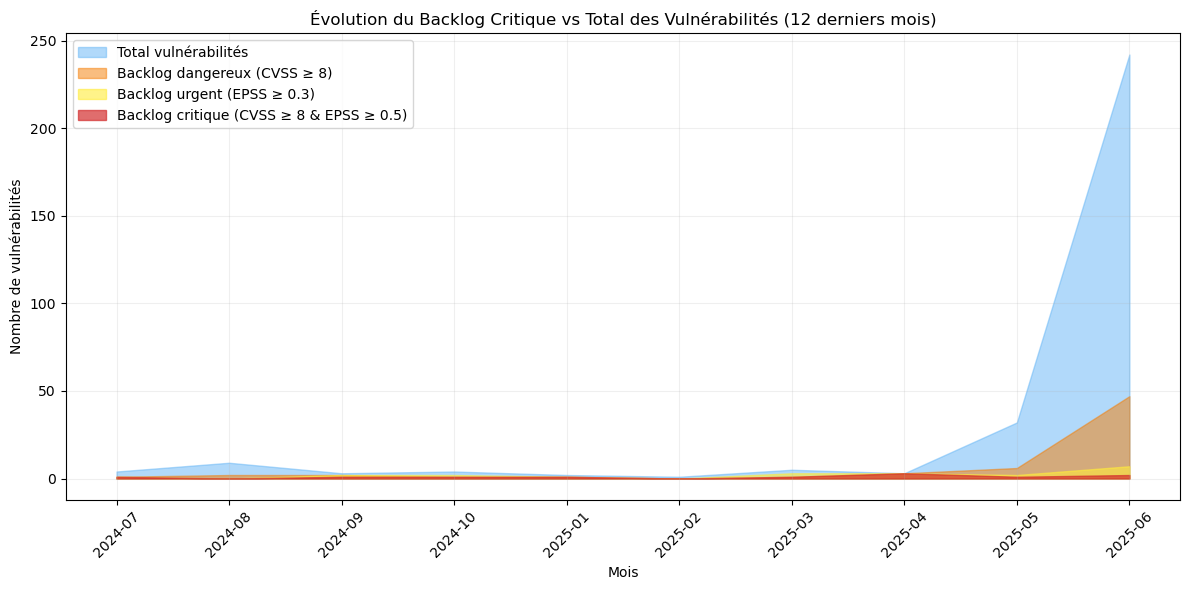

In [7]:
# Filtrer les CVE avec des scores valides
df_valid_scores = df_unique.dropna(subset=["cvss_score", "epss_score"]).copy()

# Définir la date limite (12 mois avant aujourd’hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=12)

# Filtrer dans df_valid_scores (CVE dédupliquées)
df_recent = df_valid_scores[df_valid_scores["date"] >= date_limite].copy()

# Regrouper par mois
df_recent["month"] = df_recent["date"].dt.to_period("M")

# Total CVE par mois
monthly_total = df_recent.groupby("month").size()

# Subset dangereux
danger = df_recent[(df_recent["cvss_score"] >= 8)]
monthly_danger = danger.groupby("month").size()

# Subset urgent (EPSS ≥ 0.3)
urgent = df_recent[(df_recent["epss_score"] >= 0.3)]
monthly_urgent = urgent.groupby("month").size()

# Subset critique
critical = df_recent[(df_recent["cvss_score"] >= 8) & (df_recent["epss_score"] >= 0.3)]
monthly_critical = critical.groupby("month").size()


# Aligner les index
all_months = monthly_total.index.union(monthly_critical.index).sort_values()
monthly_total = monthly_total.reindex(all_months, fill_value=0)
monthly_danger = monthly_danger.reindex(all_months, fill_value=0)
monthly_urgent = monthly_urgent.reindex(all_months, fill_value=0)
monthly_critical = monthly_critical.reindex(all_months, fill_value=0)


# Tracé Stacked Area
plt.figure(figsize=(12, 6))
plt.fill_between(all_months.astype(str), monthly_total.values, color="#64B5F6", alpha=0.5, label="Total vulnérabilités")
plt.fill_between(all_months.astype(str), monthly_danger.values, color="#F57C00", alpha=0.5, label="Backlog dangereux (CVSS ≥ 8)")
plt.fill_between(all_months.astype(str), monthly_urgent.values, color="#FFEB3B", alpha=0.6, label="Backlog urgent (EPSS ≥ 0.3)")
plt.fill_between(all_months.astype(str), monthly_critical.values, color="#D32F2F", alpha=0.7, label="Backlog critique (CVSS ≥ 8 & EPSS ≥ 0.5)")

plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.title("Évolution du Backlog Critique vs Total des Vulnérabilités (12 derniers mois)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


On observe une forte croissance entre juin 2024 et juillet 2024 (de 94 à 501), suivie d’un niveau élevé mais fluctuant jusqu’en mai 2025. Les vulnérabilités avec un score CVSS ≥ 8, signifiant un backlog dangereux, représentent en moyenne 20 à 25 % du total. Les vulnérabilités à backlog urgent sont beaucoup plus rares avec rarement plus de 8 vulnérabilités par mois. Ce faible volume montre que la probabilité d’exploitation reste faible dans la majorité des cas, malgré des scores de gravité élevés. La tendance est la même pour les backlog critiques (voire un peu plus faible). 

Grâce à cette visualisation, on peut identifier les mois où l’attention doit être portée sur un nombre élevé de vulnérabilités critiques, même s’ils ne sont pas toujours corrélés au pic de volume global.

## Analyse des faiblesses (CWE)

### Top 15 des faiblesses (CWE)

On cherche à identifier les CWE les plus fréquemment associées à des CVE et croiser cette fréquence avec la dangerosité potentielle, mesurée par la moyenne du score EPSS.

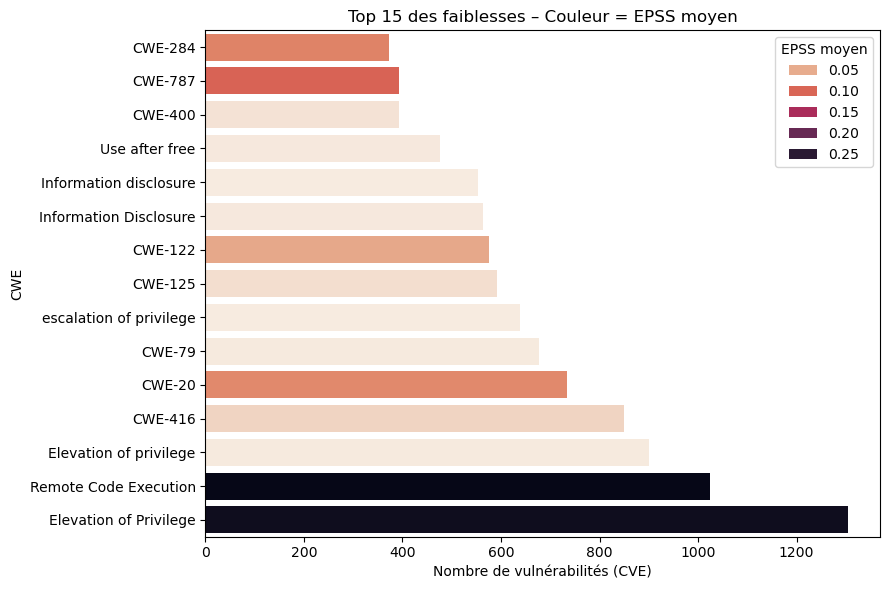

In [8]:
# 1) filtrer lignes disposant d’un CWE
d_cwe = df_unique.dropna(subset=["cwe"])

# 2) agrégation : nombre de CVE et EPSS moyen
top_cwe = (
    d_cwe.groupby("cwe", as_index=False)
         .agg(nb=("cwe", "size"),
              epss_moy=("epss_score", "mean"))
         .sort_values("nb", ascending=False)
         .head(15)
         .sort_values("nb")          # pour plot horizontal ascendant
)

# 3) barplot horizontal, palette graduée sur l’EPSS moyen
plt.figure(figsize=(9, 6))
sns.barplot(
    data=top_cwe,
    x="nb",
    y="cwe",
    hue="epss_moy",
    palette="rocket_r",
    dodge=False
)

plt.xlabel("Nombre de vulnérabilités (CVE)")
plt.ylabel("CWE")
plt.title("Top 15 des faiblesses – Couleur = EPSS moyen")
plt.legend(title="EPSS moyen", loc="upper right")
plt.tight_layout()
plt.show()

On voit d'abord que CWE-416, CWE-122, CWE-20 et CWE-79 ont les barres les plus longues, elles représentent donc les faiblesses les plus fréquentes. Pourtant, leur EPSS moyen reste faible, ce qui tempère leur criticité immédiate.

Au contraire, certaines faiblesses sont moins fréquentes sont plus dangereuses comme CWE-22 (Path Traversal) et CWE-78 (OS Command Injection). Il ne faut donc pas oublier de les considérer sérieusement malgré lmeur fréquence moindre.

### Courbe de l'évolution de différent CWE au cours du temps

L’objectif de cette visualisation est de suivre la dynamique temporelle des vulnérabilités associées à certaines failles critiques identifiées par leur identifiant CWE. On a pris les 5 plus fréquentes selon la visualisation précédente.

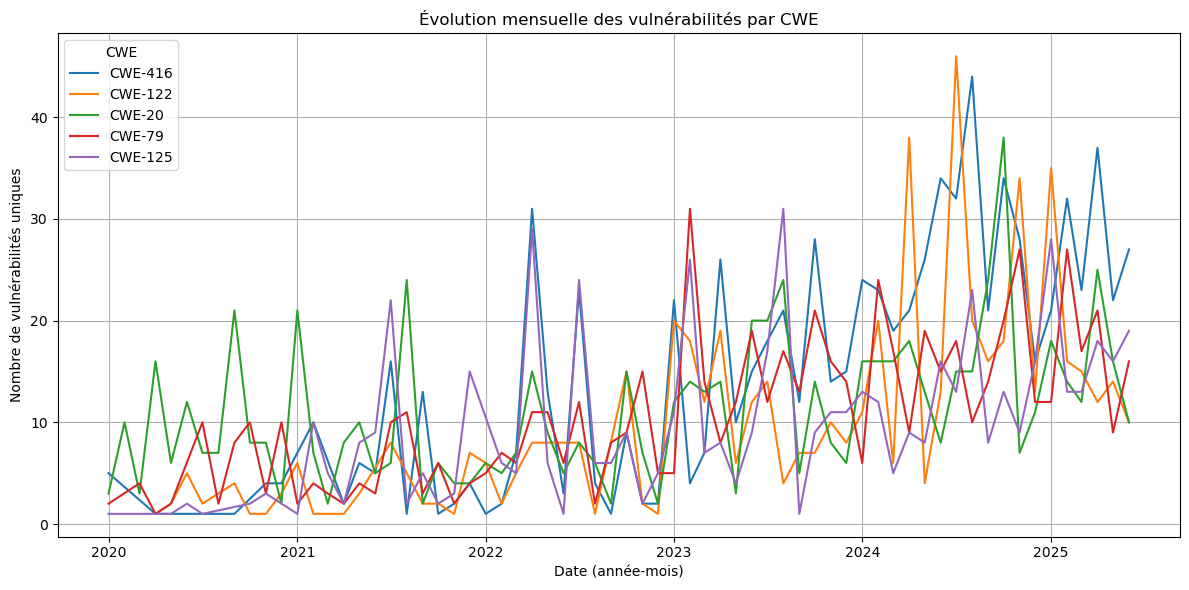

In [9]:
cwe_list = ["CWE-416", "CWE-122", "CWE-20", "CWE-79", "CWE-125"]

plt.figure(figsize=(12, 6))

for cwe in cwe_list:
    temp = df_unique[df_unique["cwe"] == cwe].copy()
    temp["date"] = pd.to_datetime(temp["date"], errors='coerce')
    temp = temp.dropna(subset=["date"])
    
    # Extraire l’année + mois
    temp["year_month"] = temp["date"].dt.to_period("M")
    
    # Compter le nombre de vulnérabilités par mois
    counts = temp["year_month"].value_counts().sort_index()
    
    # Convertir pour le tracé
    counts.index = counts.index.to_timestamp()
    
    plt.plot(counts.index, counts.values, label=cwe)

plt.title("Évolution mensuelle des vulnérabilités par CWE")
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de vulnérabilités uniques")
plt.legend(title="CWE")
plt.grid(True)
plt.tight_layout()
plt.show()


Analysons les tendances pour les 5 CWE choisies : 
* **CWE-416 – Use After Free**
    * Très faible activité avant 2023.
    * Forte augmentation continue à partir de janvier 2024, avec un pic en février 2024.
    * Reste élevée sur toute l’année 2024 et début 2025.

    ➤ Cela suggère une tendance structurelle préoccupante liée à la gestion de mémoire, possiblement favorisée par une montée en puissance de la complexité logicielle ou la découverte massive dans un sous-système.

* **CWE-122 – Heap-Based Buffer Overflow**
    * Apparition progressive en 2023.
    * Fort pic en juillet 2024 (48) et janvier 2025 (35).
    * Tendances assez irrégulières, mais plusieurs pics élevés.

    ➤ Cela peut traduire des campagnes de recherche ciblées, ou des publications groupées par certains éditeurs.  

* **CWE-20 – Improper Input Validation**
    * Présente depuis longtemps (1er cas en 2021).
    * Forte croissance dès janvier 2024, avec pics en février 2024 (41), octobre 2024 (27) et avril 2025 (25).
    
    ➤ Vulnérabilité classique mais persistante, révélatrice de pratiques de validation encore trop laxistes dans de nombreux systèmes. 

* **CWE-79 – Cross-Site Scripting (XSS)**
    * Presque absente avant 2024.
    * Forte montée à partir de février 2024 (24), avec stabilisation à un niveau moyen-haut jusqu’en 2025.
    
    ➤ Cela peut révéler une recrudescence dans les interfaces web ou une intensification des audits sur les produits exposés en ligne.

* **CWE-125 – Out-of-bounds Read**
    * Commence en 2023 avec peu de cas.
    * Forte activité entre janvier 2024 et juin 2025, avec des pics comme janvier 2025 (25) et juin 2025 (18).

    ➤ Problème courant lié aux erreurs de lecture mémoire, probablement exacerbé par des composants bas niveau mal contrôlés.

### Boxplot entre days_open et CWE

On cherche à répondre à la question : Quelles failles mettent le plus de temps à être traitées ?
Le nombre de jours ouverts (days_open) représente le temps entre la publication et la fermeture d'une CVE.

<Figure size 1200x600 with 0 Axes>

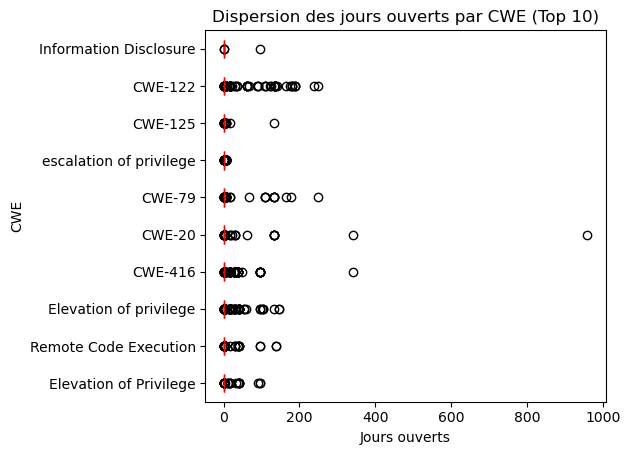

In [10]:
plt.figure(figsize=(12, 6))

# Identifier les 10 CWE les plus fréquents
top_10_CWE = df_unique["cwe"].value_counts().head(10).index

# Filtrer les lignes avec les 10 CWE les plus fréquents
subset_CWE = df_unique[df_unique["cwe"].isin(top_10_CWE)]

# Trier les CWE par fréquence
cwe_order = subset_CWE["cwe"].value_counts().index

# Boxplot horizontal avec ordre des CWE
subset_CWE.boxplot(
    column="days_open",
    by="cwe",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#1565C0", alpha=0.7),
    medianprops=dict(color="red"),
    vert=False,
    positions=range(len(cwe_order)),
)

plt.yticks(range(len(cwe_order)), cwe_order)
plt.title("Dispersion des jours ouverts par CWE (Top 10)")
plt.suptitle("")  # Supprime le titre automatique
plt.xlabel("Jours ouverts")
plt.ylabel("CWE")
plt.tight_layout()
plt.show()

On observe certaines failles avec des délais de traitement plus courts comme CWE-416 (Use After Free) qui a une médiane autour de 300 jours, avec une dispersion relativement concentrée, malgré quelques outliers. Cela montre que cette vulnérabilité est traitée de manière assez standard malgré son importance, probablement grâce à des outils d'analyse de mémoire automatisés.

Mais on a aussi des failles avec durée d’exposition plus longue ou plus variable comme CWE-400 (Resource Exhaustion) qui possède une forte dispersion, et une présence d’outliers significatifs > 800 jours. Il peut d'agir de vulnérabilités parfois sous-estimées ou difficiles à reproduire dans un environnement de test.

On a également le cas du CWE-476 (NULL Pointer Dereference) avec une très courte durée médiane et très peu de dispersion. Cela peut indiquer une détection rapide et une résolution facilitée (un crash évident par exemple).

Grâce à cette visualisation, on peut hiérarchiser les failles à résorber rapidement : les CWE avec des durées longues et des écarts importants méritent une surveillance accrue ou des politiques de remédiation renforcées.

### Histogrammes des principales vulnérabilités sur Apple

Cette visualisation vise à identifier les types de vulnérabilités les plus fréquemment rencontrées chez Apple, en se basant sur les descriptions associées aux CWE.

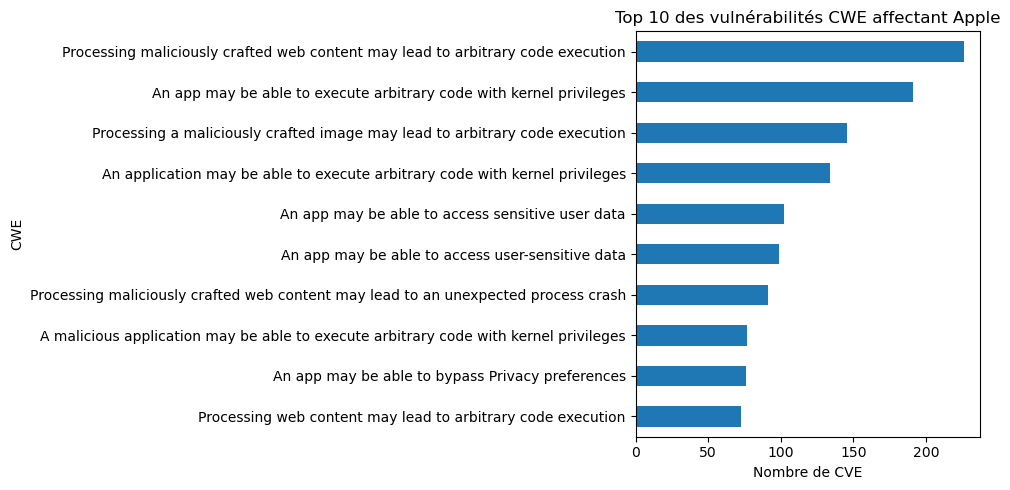

In [11]:
# 🔍 Filtrage des lignes où le vendor_std contient "apple" (insensible à la casse)
df_linux_vendor = df[df["vendor_std"].str.contains("apple", case=False, na=False)].copy()

# 🧼 On garde les lignes avec une CWE valide
df_linux_vendor = df_linux_vendor.dropna(subset=["cwe"])

# 📊 Compte des CWE affectant ce fournisseur
top_cwe_linux_vendor = (
    df_linux_vendor["cwe"]
    .value_counts()
    .head(10)
)

# 📈 Affichage
plt.figure(figsize=(10, 5))
top_cwe_linux_vendor.plot(kind="barh")
plt.title("Top 10 des vulnérabilités CWE affectant Apple")
plt.xlabel("Nombre de CVE")
plt.ylabel("CWE")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



Les 3 vulnérabilités les plus fréquentes sont :
* “Processing maliciously crafted web content may lead to an unexpected process crash” (~85 CVE)
    
    → Il s'agit d'une vulnérabilité fréquente dans les moteurs de rendu et peut être exploitée à distance via le navigateur ou les vues intégrées dans les apps.

* “An app may be able to access sensitive user data” (~75 CVE)
    
    → Risque direct pour la vie privée, contournement des mécanismes de sandboxing ou de permissions.

* “An app may be able to access user-sensitive data” (~60 CVE)
    
    → Formulation voisine de la précédente, indiquant une faille structurelle dans la gestion des accès aux données sur les appareils Apple.

On observe que chez Apple, les vulnérabilités se concentrent autour des crashs provoqués par contenu malicieux (notamment web), de l’exposition involontaire de données utilisateur et de l’élargissement abusif des droits d’accès des apps.

## Analyse par éditeur / fournisseur

### Histogramme des vendeurs les plus affectés par CVE distincts

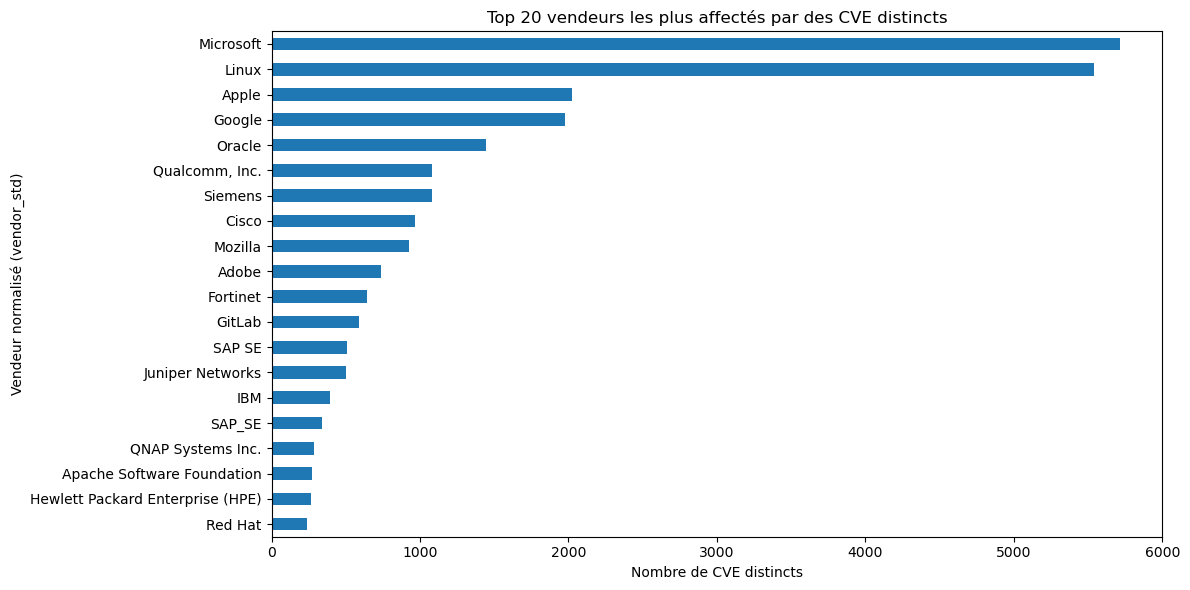

In [12]:
# On filtre les lignes ayant un vendor_std et une cve valides
df_cve = df.dropna(subset=["vendor_std", "cve"]).copy()

# Compte du nombre de CVE distincts par vendor_std
cve_par_vendor = (
    df_cve.groupby("vendor_std")["cve"]
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

# Affichage du graphique
plt.figure(figsize=(12, 6))
cve_par_vendor.plot(kind="barh")
plt.title("Top 20 vendeurs les plus affectés par des CVE distincts")
plt.xlabel("Nombre de CVE distincts")
plt.ylabel("Vendeur normalisé (vendor_std)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Histogramme des vendeurs les plus affectés par CWE distincts

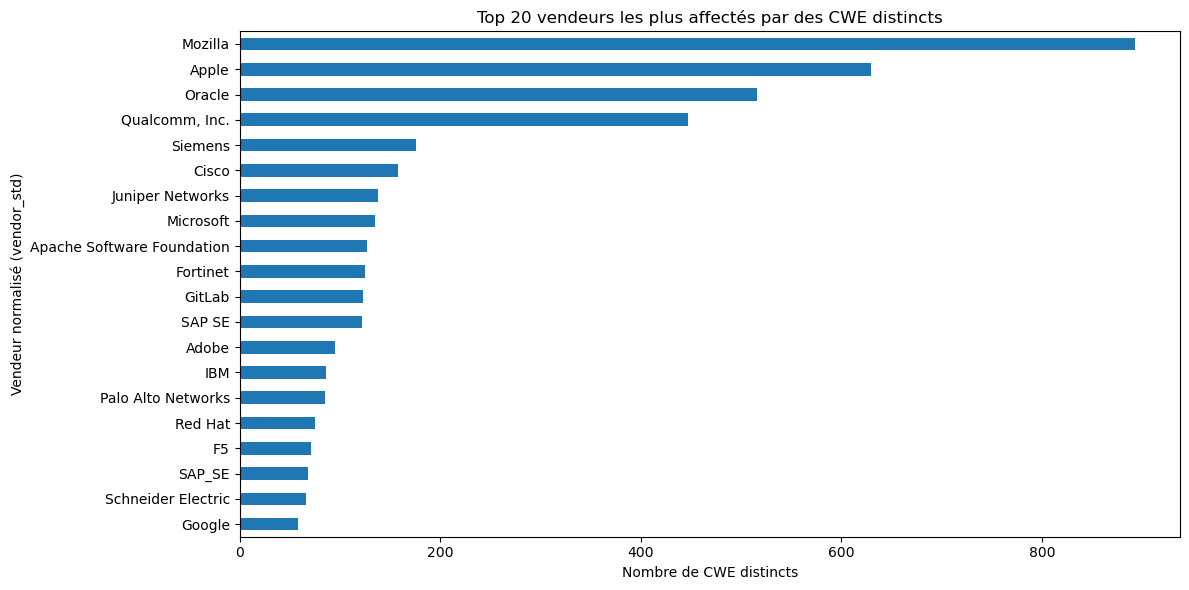

In [13]:
# On filtre les lignes ayant un vendor_std et une cwe valides
df_cwe = df.dropna(subset=["vendor_std", "cwe"]).copy()

# Compte du nombre de CWE distincts par vendor_std
cwe_par_vendor = (
    df_cwe.groupby("vendor_std")["cwe"]
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

# Affichage du graphique
plt.figure(figsize=(12, 6))
cwe_par_vendor.plot(kind="barh")
plt.title("Top 20 vendeurs les plus affectés par des CWE distincts")
plt.xlabel("Nombre de CWE distincts")
plt.ylabel("Vendeur normalisé (vendor_std)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Histogramme de comparaison CVE totales vs CVE avec CWE

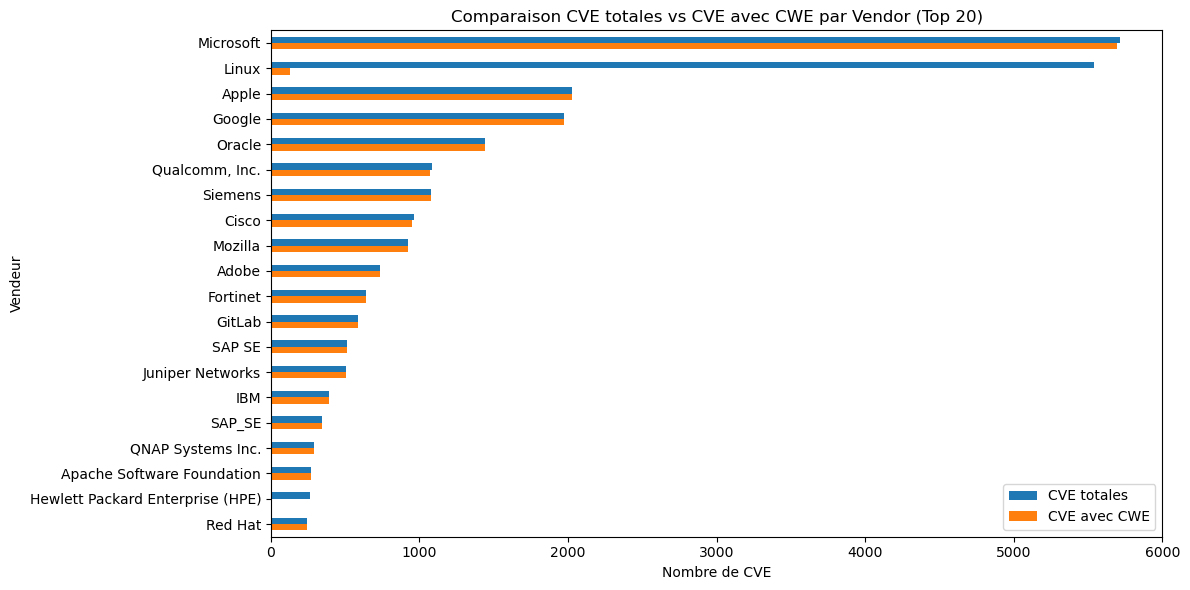

In [14]:
# 📌 On garde les lignes avec vendor_std et cve valides
df_valid = df.dropna(subset=["vendor_std", "cve"]).copy()

# 📌 Nombre total de CVE distincts par vendeur
cve_par_vendor = df_valid.groupby("vendor_std")["cve"].nunique()

# 📌 Nombre de CVE distincts avec une CWE valide
df_with_cwe = df_valid.dropna(subset=["cwe"])
cve_avec_cwe_par_vendor = df_with_cwe.groupby("vendor_std")["cve"].nunique()

# 📌 Fusion des deux séries en DataFrame
df_comparatif = pd.DataFrame({
    "CVE_total": cve_par_vendor,
    "CVE_avec_CWE": cve_avec_cwe_par_vendor
}).fillna(0)

# 📌 Sélection des 20 vendeurs les plus affectés (par CVE_total)
top20 = df_comparatif.sort_values(by="CVE_total", ascending=False).head(20)

# 📈 Affichage
top20.plot(kind="barh", figsize=(12, 6))
plt.title("Comparaison CVE totales vs CVE avec CWE par Vendor (Top 20)")
plt.xlabel("Nombre de CVE")
plt.ylabel("Vendeur")
plt.gca().invert_yaxis()
plt.legend(["CVE totales", "CVE avec CWE"])
plt.tight_layout()
plt.show()


### Boxplot des scores CVSS par éditeur

Montrer **la dispersion des scores CVSS** pour les éditeurs les plus affectés.

<Figure size 1200x600 with 0 Axes>

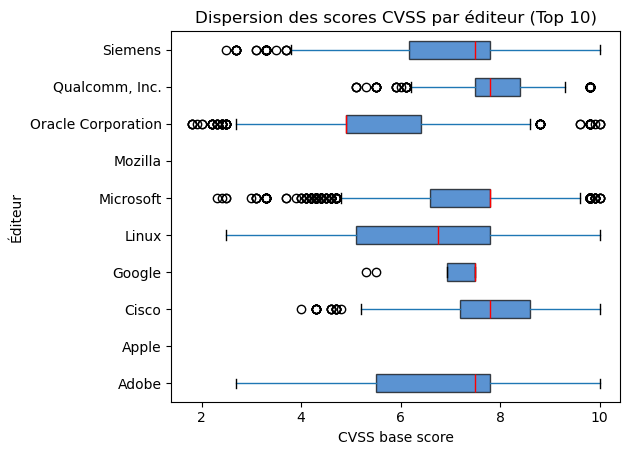

In [15]:
plt.figure(figsize=(12, 6))

# Top 10 éditeurs selon le nombre de CVE uniques
top_vendors = df_unique["vendor"].value_counts().head(10).index
subset_top_vendors = df_unique[df_unique["vendor"].isin(top_vendors)]

# Boxplot horizontal
subset_top_vendors.boxplot(
    column="cvss_score",
    by="vendor",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#1565C0", alpha=0.7),
    medianprops=dict(color="red"),
    vert=False
)

plt.title("Dispersion des scores CVSS par éditeur (Top 10)")
plt.suptitle("")  # Supprime le titre automatique
plt.xlabel("CVSS base score")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()


### Heat-map Vendor × CWE

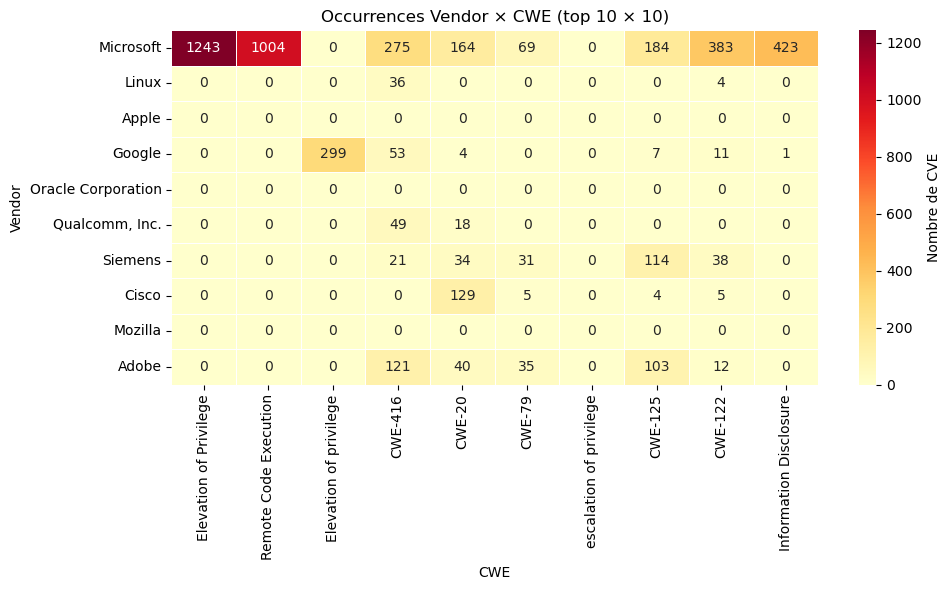

In [16]:
# 1) périmètre raisonnable : top 10 vendors & top 10 CWE
top_vendors = df_unique["vendor"].value_counts().head(10).index
top_cwes    = df_unique["cwe"].value_counts().head(10).index

sub = df_unique[df_unique["vendor"].isin(top_vendors) & df_unique["cwe"].isin(top_cwes)]

# 2) matrice Vendor × CWE
pivot = (
    sub.groupby(["vendor", "cwe"])
       .size()
       .unstack(fill_value=0)
)

# 3) forcer l’ordre ET compléter les manquants avec 0
pivot = pivot.reindex(index=top_vendors, columns=top_cwes, fill_value=0)

# 4) tracé heat-map
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True, fmt="d", linewidths=.5,
    cmap="YlOrRd", cbar_kws={"label": "Nombre de CVE"}
)
plt.title("Occurrences Vendor × CWE (top 10 × 10)")
plt.xlabel("CWE")
plt.ylabel("Vendor")
plt.tight_layout()
plt.show()

### Top 3 vulnérabilités CWE pour les 10 principaux vendeurs

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

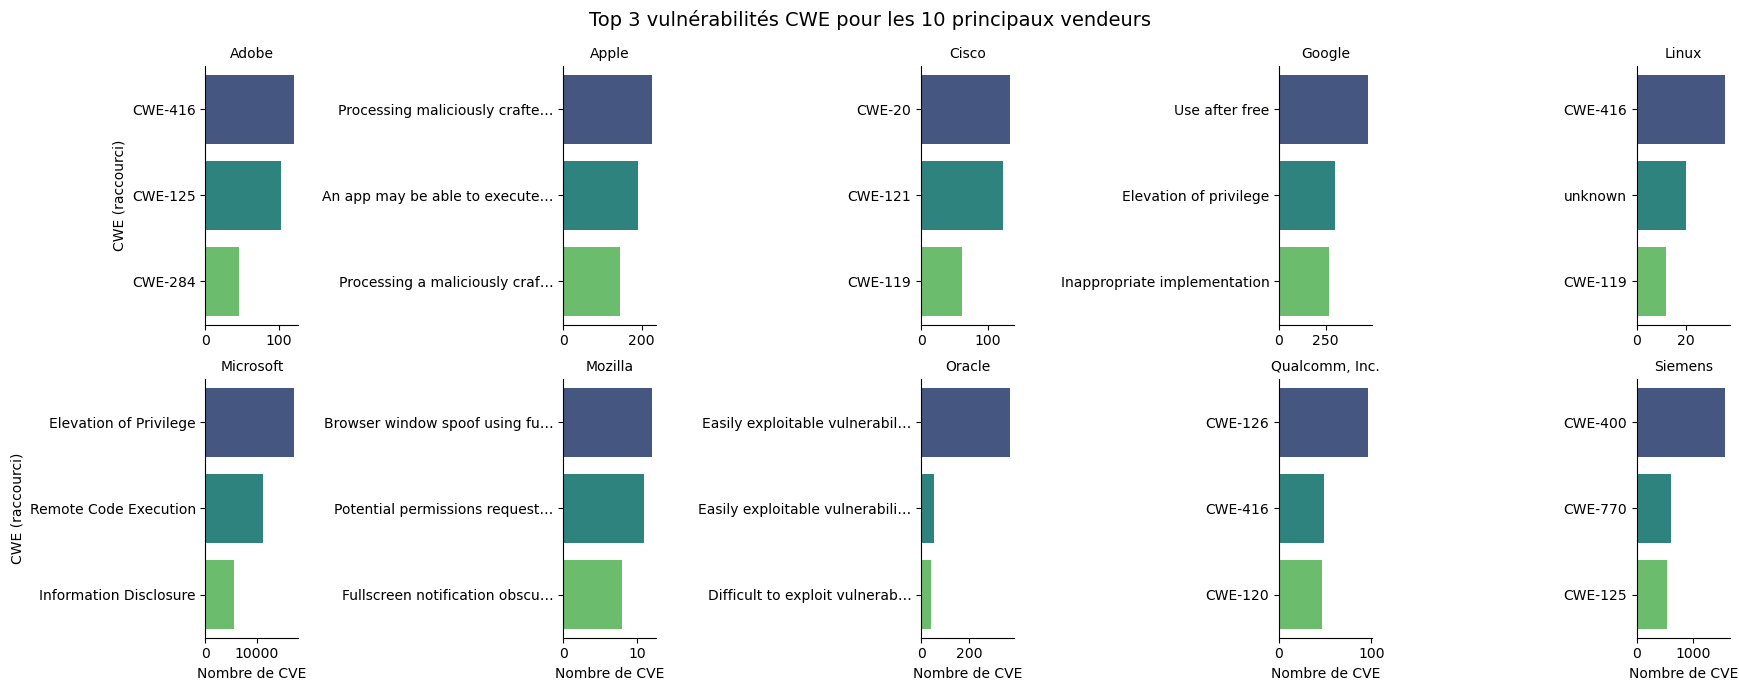

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Étape 1 : top-10 vendeurs
top_10_vendors = (
    df.dropna(subset=["vendor_std", "cve"])
      .groupby("vendor_std")["cve"]
      .nunique()
      .sort_values(ascending=False)
      .head(10)
      .index
)

# 🔹 Étape 2 : lignes pertinentes
df_cwe_vendors = (
    df[df["vendor_std"].isin(top_10_vendors)]
      .dropna(subset=["cwe"])
)

# 🔹 Étape 3 : compte des CWE par vendeur
cwe_counts = (
    df_cwe_vendors
    .groupby(["vendor_std", "cwe"])
    .size()
    .reset_index(name="count")
)

# 🔹 Étape 4 : top-3 CWE par vendeur
top_cwes_per_vendor = (
    cwe_counts
    .sort_values(["vendor_std", "count"], ascending=[True, False])
    .groupby("vendor_std")
    .head(3)
)

# ───────────────────────────────────────────────────────────────
# 🔹 Étape 4 bis : création d'un label court mais unique
MAX_LEN = 30       # longueur cible « idéale »

def make_unique_short(series, max_len=MAX_LEN):
    """
    Pour chaque valeur de `series`, retourne une version raccourcie :
    - d'abord coupée à max_len ;
    - si doublon, on rallonge jusqu'à unicité (ou le nom complet).
    """
    used = set()
    short_list = []
    for full in series:
        # longueur courante que l'on peut faire évoluer
        cur_len = min(max_len, len(full))
        while True:
            short = full if len(full) <= cur_len else full[:cur_len-1] + "…"
            if short not in used:
                used.add(short)
                short_list.append(short)
                break
            # doublon → on révèle 1 caractère de plus
            if cur_len < len(full):
                cur_len += 1
            else:           # le nom entier est identique : on ne peut pas faire mieux
                # (cela ne devrait jamais arriver sauf si deux CWE identiques)
                short += " "  # force la différence
                used.add(short)
                short_list.append(short)
                break
    return short_list

top_cwes_per_vendor["cwe_short"] = (
    top_cwes_per_vendor
        .groupby("vendor_std")["cwe"]
        .transform(make_unique_short)
)

# ───────────────────────────────────────────────────────────────
# 🔹 Étape 5 : FacetGrid
g = sns.FacetGrid(
    top_cwes_per_vendor,
    col="vendor_std",
    col_wrap=5,
    height=3.5,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.barplot, y="cwe_short", x="count", palette="viridis")

# 🔹 Étape 6 : titres & labels
g.set_titles("{col_name}")
g.set_axis_labels("Nombre de CVE", "CWE (raccourci)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Top 3 vulnérabilités CWE pour les 10 principaux vendeurs", fontsize=14)
plt.show()


### CVE / an pour les 5 éditeurs majeurs

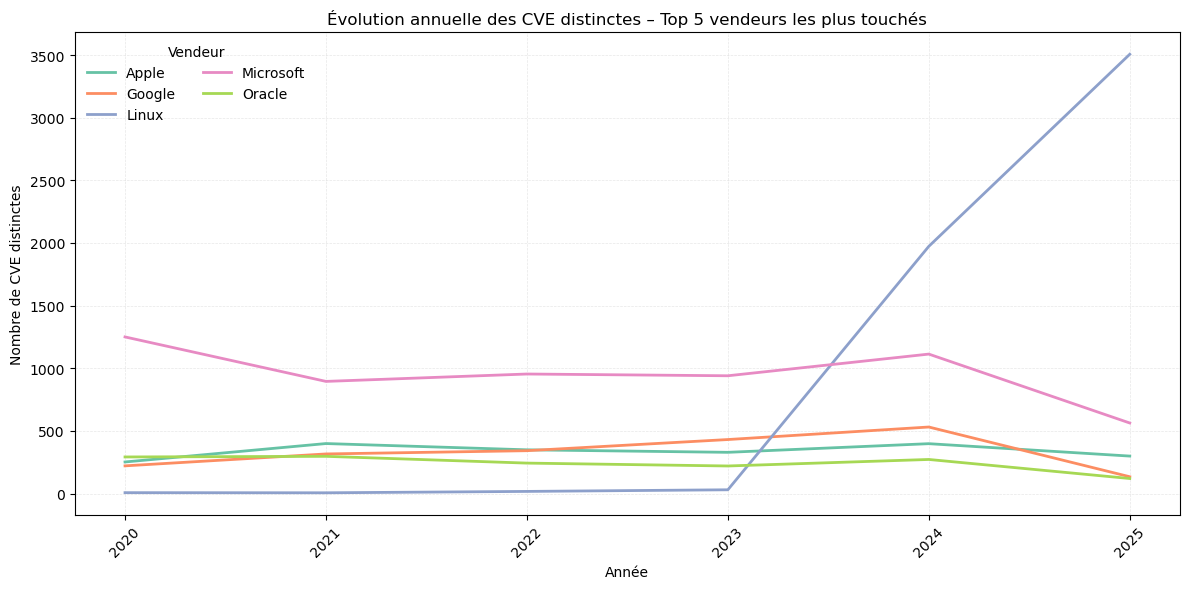

In [18]:
# ─── 0. Base fiable : une ligne par (vendor, cve) ──────────────────────
clean = (
    df_unique
    .dropna(subset=["vendor_std", "date", "cve"])
    .assign(year=lambda d: d["date"].dt.year)
    .drop_duplicates(subset=["vendor_std", "cve"])  # une seule ligne par CVE unique
)

# ─── 1. Top-5 vendeurs les plus affectés (tous temps confondus) ───────
top5 = (
    clean["vendor_std"]
    .value_counts()
    .head(5)
    .index
)

# ─── 2. Comptage annuel des CVE par vendeur ───────────────────────────
pivot = (
    clean[clean["vendor_std"].isin(top5)]
    .groupby(["year", "vendor_std"])
    .size()
    .unstack(fill_value=0)  # lignes = années, colonnes = vendeurs
    .sort_index()
)

# ─── 3. Compléter les années manquantes ───────────────────────────────
full_years = pd.RangeIndex(pivot.index.min(), pivot.index.max() + 1)
pivot = pivot.reindex(full_years, fill_value=0)

# ─── 4. Tracé multi-séries lisible ─────────────────────────────────────
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2", n_colors=len(top5))

for i, vendor in enumerate(pivot.columns):
    plt.plot(
        pivot.index, pivot[vendor],
        label=vendor, color=palette[i], linewidth=2
    )

plt.title("Évolution annuelle des CVE distinctes – Top 5 vendeurs les plus touchés")
plt.xlabel("Année")
plt.ylabel("Nombre de CVE distinctes")
plt.xticks(pivot.index, rotation=45)
plt.grid(alpha=.3, linestyle="--", linewidth=.5)
plt.legend(title="Vendeur", ncol=2, frameon=False)
plt.tight_layout()
plt.show()


## Analyse des bulletins et médiatisation

### Treemap Bulletins, pour la taille d'impact des bulletins

Déniche les bulletins "massifs", parfois sous-estimés


In [19]:
import plotly.express as px

# Définir la date limite (6 mois avant aujourd'hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=4)

# Calcul le nombre de produits affectés par CVE
df["n_affected_products"] = df["versions"].apply(lambda x: len(str(x).split("|")) if pd.notnull(x) else 0)

# Filtre pour les 100 plus impactants
top_50_alertes_avis = df[df["type"].isin(["alerte", "avis"])].nlargest(200, "n_affected_products")

# Filtrer les bulletins récents
bulletins_recents = top_50_alertes_avis[top_50_alertes_avis["date"] >= date_limite]

# Agrégation pour la treemap
treemap_data = bulletins_recents.groupby(["type", "id_anssi", "date"]).agg(
    n_affected_products=("n_affected_products", "sum"),
    titre=("titre", "first")
).reset_index()


treemap_data = treemap_data.sort_values(by="n_affected_products", ascending=False)


# Créer une treemap avec plotly.express
fig = px.treemap(
    treemap_data,
    path=["type", "date","id_anssi", "titre"],
    color="n_affected_products",
    values="n_affected_products",
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(treemap_data['n_affected_products'], weights=treemap_data['n_affected_products'])
)

fig.update_layout(
    title="Treemap Bulletins - Taille d'impact des bulletins",
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()

ZeroDivisionError: Weights sum to zero, can't be normalized

### Scatter Nombre de références avec EPSS : Attention il faudrait récupérer les données n_cve_refs

Evalue la popularité/médiatisation. Plus de sources implique un risque médiatique et une exploitation probable

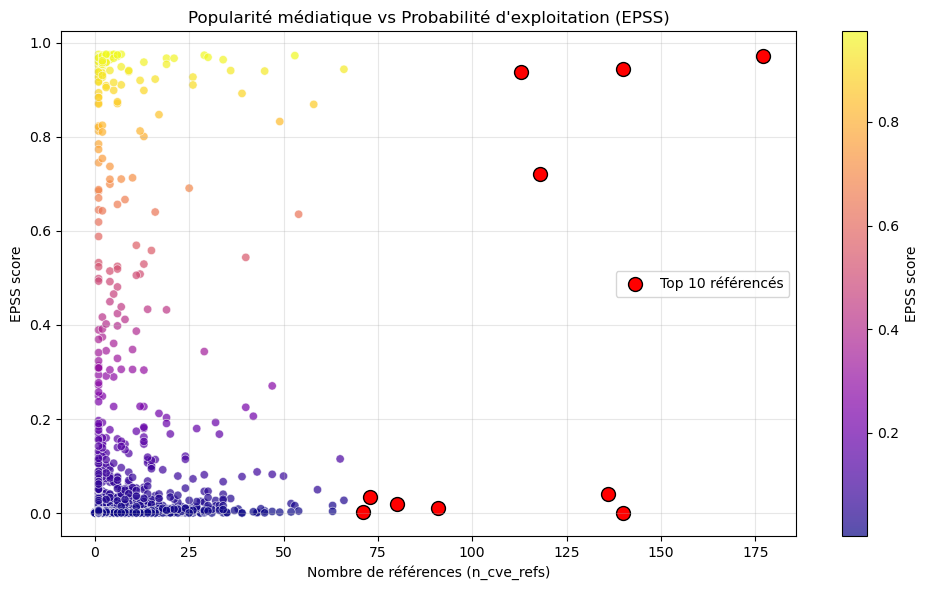

Top 10 des cas les plus référencés :
╒════════╤════════════════╤══════════════╤══════════════╤══════════════╤════════════╕
│        │ cve            │   n_cve_refs │   epss_score │   cvss_score │ cvss_sev   │
╞════════╪════════════════╪══════════════╪══════════════╪══════════════╪════════════╡
│ 129486 │ CVE-2014-6271  │          177 │      0.97214 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│      0 │ CVE-2023-44487 │          140 │      0.94434 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│  11661 │ CVE-2020-27216 │          140 │      0.00074 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│  91346 │ CVE-2016-2183  │          136 │      0.03984 │        nan   │ nan        │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│   2279 │ CVE-20

In [ ]:
from tabulate import tabulate

# Trier les données par le nombre de références (n_cve_refs) en ordre décroissant
top_referenced_cases = df_unique.nlargest(10, "n_cve_refs").copy()

# Mettre en évidence ces cas dans le graphique
plt.figure(figsize=(10, 6))

# Tracé du nuage de points
scatter = plt.scatter(
    df_unique["n_cve_refs"],
    df_unique["epss_score"],
    c=df_unique["epss_score"],  # Utiliser les scores EPSS pour la couleur
    alpha=0.7,
    edgecolors="white",
    cmap="plasma",
    linewidths=0.5
)

# Ajouter les cas top 10 avec une couleur différente
plt.scatter(
    top_referenced_cases["n_cve_refs"],
    top_referenced_cases["epss_score"],
    color="red",
    edgecolors="black",
    label="Top 10 référencés",
    s=100
)

# Ajouter une barre de couleur
plt.colorbar(scatter, label="EPSS score")

plt.xlabel("Nombre de références (n_cve_refs)")
plt.ylabel("EPSS score")
plt.title("Popularité médiatique vs Probabilité d'exploitation (EPSS)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher le tableau complémentaire

print("Top 10 des cas les plus référencés :")
print(tabulate(
    top_referenced_cases[["cve", "n_cve_refs", "epss_score", "cvss_score", "cvss_sev"]],
    headers="keys",
    tablefmt="fancy_grid"
))

### Scatter nombre de révisions avec EPSS

Permet d'établir à quel point une vulnérabilité est changeante et si elle a besoin d'un attention particulière

In [ ]:
plt.figure(figsize=(10, 6))

# Mettre en évidence ces cas dans le graphique
top_referenced_cases = df_unique.nlargest(10, "n_revisions").copy()

# Tracé du nuage de points
scatter = plt.scatter(
    df_unique["n_revisions"],
    df_unique["epss_score"],
    c=df_unique["cvss_score"],  # Utiliser les scores EPSS pour la couleur
    cmap="PuBuGn",
    alpha=0.7,
    edgecolors="white",
    linewidths=0.5
)

# Ajouter les cas top 10 avec une couleur différente
plt.scatter(
    top_referenced_cases["n_revisions"],
    top_referenced_cases["epss_score"],
    c="red",
    edgecolors="black",
    label="Top 10 révisés",
    s=100,
)

# Ajouter une barre de couleur
plt.colorbar(scatter, label="CVSS score")

plt.xlabel("Nombre de révisions (n_revisions)")
plt.ylabel("EPSS base score")
plt.title("Nombre de révisions vs EPSS score (coloré par CVSS score)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher le tableau complémentaire

print("Top 10 des cas les plus révisés :")
print(tabulate(
    top_referenced_cases[["cve", "type", "n_revisions", "cvss_score", "epss_score", "cvss_sev"]],
    headers="keys",
    tablefmt="fancy_grid"
))

KeyError: 'n_revisions'

<Figure size 1000x600 with 0 Axes>

## **Résultats du modèle de classification (Random Forest)**

Nous avons entraîné un modèle de type Random Forest pour prédire la gravité (cvss_sev) d’une vulnérabilité à partir de plusieurs variables : le score CVSS, le score EPSS, le percentile EPSS et le nombre de jours depuis la publication (days_open).

Les résultats obtenus sont très bons. Le rapport de classification montre une précision, un rappel et un score F1 de 1.00 pour les classes principales : CRITICAL, HIGH, MEDIUM et LOW. Seule la classe NONE est un peu moins bien prédite. Cela s’explique par le fait qu’elle ne contient que deux exemples dans l’ensemble de test, ce qui rend l’évaluation peu représentative.

La matrice de confusion confirme ces performances. Le modèle classe correctement presque toutes les observations. On observe une seule confusion entre la classe LOW et NONE, ce qui est négligeable par rapport au nombre total d’exemples.

**Interprétation des résultats**

Ces résultats montrent que le modèle est capable de prédire de manière fiable la gravité d’une vulnérabilité, même lorsqu’elle n’est pas fournie directement. Les variables utilisées sont suffisamment informatives pour permettre une bonne séparation entre les classes.

Cela est très utile dans notre projet, car certaines vulnérabilités ne sont pas toujours accompagnées d’un niveau de gravité clair. Grâce à ce modèle, nous pouvons estimer ce niveau automatiquement.

**Utilité pour la suite du projet**

L’intégration de ce modèle dans notre pipeline permet de renforcer le système de détection des vulnérabilités critiques. Lorsqu’une faille est prédite comme critique par le modèle, même si elle n’est pas encore officiellement classée, une alerte peut être déclenchée.

Par exemple, si une CVE présente un score EPSS élevé mais n’a pas encore de gravité assignée, le modèle peut prédire qu’elle est critique. Cela permet d’envoyer une notification sans attendre les mises à jour officielles.

## **Résultats du modèle de regroupement (KMeans)**

Nous avons utilisé l’algorithme KMeans pour regrouper les vulnérabilités en fonction de leurs caractéristiques, sans utiliser d’étiquette de gravité. C’est une méthode non supervisée, qui cherche à créer des groupes d’éléments similaires.

Avant d’appliquer le modèle, nous avons réduit le nombre de dimensions grâce à une analyse en composantes principales (PCA). Cela permet de visualiser les données sur un graphique en deux dimensions.

Le graphique obtenu montre plusieurs groupes bien distincts. Chaque couleur représente un groupe (ou cluster) de vulnérabilités qui partagent des caractéristiques communes.
Interprétation des résultats

Les résultats montrent que les vulnérabilités peuvent être classées automatiquement en différents groupes. Chaque groupe contient des vulnérabilités qui se ressemblent :
- Un groupe peut contenir des vulnérabilités très graves, avec un score élevé et un fort risque d’exploitation.
- Un autre groupe peut regrouper des failles moins graves ou plus anciennes.
- Certains groupes sont très compacts (vulnérabilités très similaires), d'autres plus dispersés (vulnérabilités plus variées).

Cela permet de mieux comprendre les types de vulnérabilités présents dans les données.

**Utilité pour le projet**

Ce modèle est très utile pour notre projet. Il nous permet de :
classer automatiquement les vulnérabilités, même quand nous ne connaissons pas encore leur gravité, d'identifier les groupes les plus à risque, pour mieux prioriser les actions à mener, et enfin repérer des anomalies, c’est-à-dire des failles qui ne ressemblent à aucune autre.

Par exemple, si un groupe contient souvent des vulnérabilités critiques, alors toutes les nouvelles failles qui entrent dans ce groupe doivent être surveillées de près.